In [2]:
from typing import Annotated
from typing_extensions import TypedDict

## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

In [6]:
## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [7]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [8]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [9]:
tools=[wiki_tool]

In [10]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [12]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
# Load environment variables from .env
load_dotenv()

True

In [14]:
groq_api_key=os.getenv('groq_api_key')
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [15]:
graph_builder= StateGraph(State)

In [16]:
llm_with_tools=llm.bind_tools(tools=tools)

In [17]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [18]:
from langgraph.prebuilt import ToolNode,tools_condition

In [19]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [20]:
graph=graph_builder.compile()

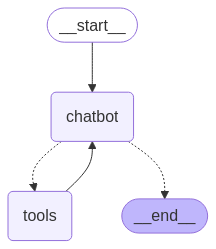

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_t49f)
 Call ID: call_t49f
  Args:
    query: John


C:\Users\Abhishek Jaiswal\.conda\envs\myenv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Abhishek Jaiswal\.conda\envs\myenv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

Hi John, it's nice to meet you!


In [25]:
user_input = "what is RLHF & Transformers."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF & Transformers.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9fbq)
 Call ID: call_9fbq
  Args:
    query: RLHF & Transformers
================================= Tool Message =================================
Name: wikipedia

Page: Transformer (deep learning architecture)
Summary: The transformer is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper "Attention Is All You Need". Text is converted to numerical rep
================================== Ai Message ==================================

Transformers are a type of deep learning architecture. 

RLHF stands for Reinforcement Learning from Human Feedback. It's a technique used to train AI models, like transformers, to be more aligned with human preferences.
